In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
tf.__version__

'2.10.0'

In [3]:
os.listdir(r'D:\Project\tensorflow\mc\annotations\trimaps')[-5:]

['yorkshire_terrier_95.png',
 'yorkshire_terrier_96.png',
 'yorkshire_terrier_97.png',
 'yorkshire_terrier_98.png',
 'yorkshire_terrier_99.png']

In [4]:
img = tf.io.read_file(r'D:\Project\tensorflow\mc\annotations\trimaps\yorkshire_terrier_99.png')

In [5]:
img = tf.image.decode_png(img)

In [6]:
img.shape

TensorShape([358, 500, 1])

In [7]:
#一维没有意义，可以直接压缩舍弃

In [8]:
img = tf.squeeze(img)

In [9]:
img.shape

TensorShape([358, 500])

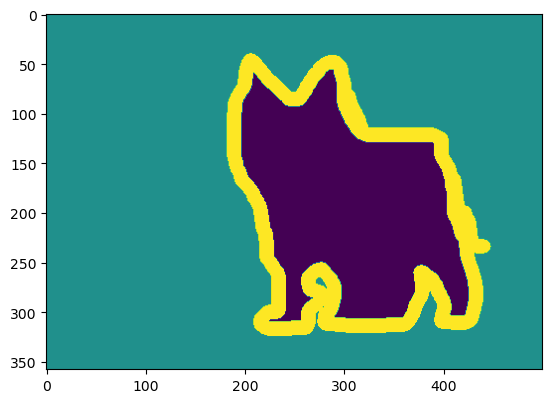

In [10]:
plt.imshow(img)

In [11]:
img.numpy().max()

3

In [12]:
img.numpy().min()

1

In [13]:
#所以这个图片分别用123来标志这三类
np.unique(img.numpy())

array([1, 2, 3], dtype=uint8)

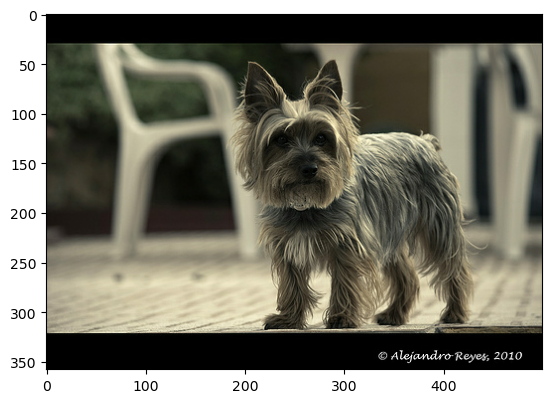

In [14]:
#查看原有图片
img = tf.io.read_file(r'D:\Project\tensorflow\mc\images\yorkshire_terrier_99.jpg')
img = tf.image.decode_jpeg(img)
plt.imshow(img)

In [15]:
import glob

In [16]:
images = glob.glob(r'D:\Project\tensorflow\mc\images\*.jpg')

In [17]:
images[:3]

['D:\\Project\\tensorflow\\mc\\images\\Abyssinian_1.jpg',
 'D:\\Project\\tensorflow\\mc\\images\\Abyssinian_10.jpg',
 'D:\\Project\\tensorflow\\mc\\images\\Abyssinian_100.jpg']

In [18]:
len(images)

7390

In [19]:
anno = glob.glob(r'D:\Project\tensorflow\mc\annotations\trimaps\*.png')

In [20]:
anno[:3]

['D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\Abyssinian_1.png',
 'D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\Abyssinian_10.png',
 'D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\Abyssinian_100.png']

In [21]:
len(anno)

7390

In [22]:
anno[-5:]

['D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\yorkshire_terrier_95.png',
 'D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\yorkshire_terrier_96.png',
 'D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\yorkshire_terrier_97.png',
 'D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\yorkshire_terrier_98.png',
 'D:\\Project\\tensorflow\\mc\\annotations\\trimaps\\yorkshire_terrier_99.png']

In [23]:
images[-5:]

['D:\\Project\\tensorflow\\mc\\images\\yorkshire_terrier_95.jpg',
 'D:\\Project\\tensorflow\\mc\\images\\yorkshire_terrier_96.jpg',
 'D:\\Project\\tensorflow\\mc\\images\\yorkshire_terrier_97.jpg',
 'D:\\Project\\tensorflow\\mc\\images\\yorkshire_terrier_98.jpg',
 'D:\\Project\\tensorflow\\mc\\images\\yorkshire_terrier_99.jpg']

In [24]:
#可以看出两列表关系是一一对应的，不放心可以进行排序

In [25]:
np.random.seed(2019)
index = np.random.permutation(len(images))

In [26]:
images = np.array(images)[index]
anno = np.array(anno)[index]

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((images,anno))

In [28]:
test_count = int(len(images)*0.2)
train_count = len(images)-test_count

In [29]:
test_count, train_count

(1478, 5912)

In [30]:
data_train = dataset.skip(test_count)
data_test = dataset.take(test_count)

In [31]:
#对图片进行预处理
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [32]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [33]:
#归一化
def normal_img(input_images, input_anno):
    input_images = tf.cast(input_images, tf.float32)
    input_images = input_images/127.5-1
    input_anno = input_anno-1 #由123变为012
    return input_images, input_anno

In [34]:
#加载函数
def load_images(input_images_path,input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    input_image = tf.image.resize(input_image,(224,224))
    input_anno = tf.image.resize(input_anno,(224,224))
    return normal_img(input_image,input_anno)

In [35]:
data_train = data_train.map(load_images)
data_test = data_test.map(load_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [36]:
BATCH_SIZE = 8

In [37]:
data_train = data_train.repeat().shuffle(100).batch(BATCH_SIZE)

In [38]:
data_test = data_test.batch(BATCH_SIZE)

In [39]:
data_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

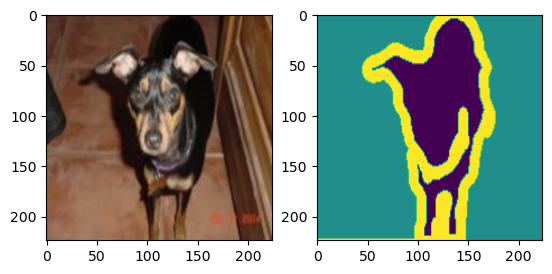

In [40]:
#在处理好的数据集中取出一组图像进行查看
for img,anno in data_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

In [41]:
 #使用VGG16预训练网络

In [42]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                       input_shape=(224,224,3),
                                       include_top=False)

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [44]:
#获取中间的输出
#最后的输出 进行上采样 与 block5_conv3 相加 再....

In [45]:
#拿到这层输出
conv_base.get_layer('block5_conv3').output

<KerasTensor: shape=(None, 14, 14, 512) dtype=float32 (created by layer 'block5_conv3')>

In [46]:
#创建子模型 子模型也会继承权重
sub_model = tf.keras.models.Model(inputs=conv_base.input,
                                outputs=conv_base.get_layer('block5_conv3').output)

In [47]:
sub_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [48]:
#一次性获取多个输出 创建多输出模型
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

In [49]:
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]

In [50]:
multi_out_model = tf.keras.models.Model(inputs=conv_base.input,
                                outputs=layers_output)

In [51]:
multi_out_model.trainable = False

In [52]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
out_block5_conv3, out_block4_conv3, out_block3_conv3, out_block5_pool = multi_out_model(inputs)

In [53]:
out_block5_pool.shape

TensorShape([None, 7, 7, 512])

In [54]:
out_block5_conv3.shape

TensorShape([None, 14, 14, 512])

In [55]:
#上采样 
x1 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(out_block5_pool) #strides=2设置跨度为2图形变为原来的两倍,即转置卷积，same为相同大小的填充

In [56]:
x1.shape #由([None, 7, 7, 512])变为

TensorShape([None, 14, 14, 512])

In [57]:
#添加一层卷积来提取特征
x1 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x1)

In [58]:
x1.shape

TensorShape([None, 14, 14, 512])

In [59]:
#加上前面的输出
x2 = tf.add(x1,out_block5_conv3)

In [60]:
x2.shape

TensorShape([None, 14, 14, 512])

In [61]:
#对x2进行上采样
x2 = tf.keras.layers.Conv2DTranspose(512, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(x2)

In [62]:
x2.shape

TensorShape([None, 28, 28, 512])

In [63]:
#添加一层卷积来提取特征
x2 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x2)

In [64]:
x2.shape

TensorShape([None, 28, 28, 512])

In [65]:
x3 = tf.add(x2, out_block4_conv3)

In [66]:
x3.shape

TensorShape([None, 28, 28, 512])

In [67]:
x3 = tf.keras.layers.Conv2DTranspose(256, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(x3)

In [68]:
x3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x3)

In [69]:
x3.shape

TensorShape([None, 56, 56, 256])

In [70]:
x4 = tf.add(x3, out_block3_conv3)

In [71]:
x4.shape

TensorShape([None, 56, 56, 256])

In [72]:
#目标输出是一个分类 输出图形与原图形大小相同

In [73]:
x5 = tf.keras.layers.Conv2DTranspose(128, 3, 
                                     strides=2, 
                                     padding='same',
                                     activation='relu')(x4)

In [74]:
x5.shape

TensorShape([None, 112, 112, 128])

In [75]:
x5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x5)

In [76]:
prediction = tf.keras.layers.Conv2DTranspose(3, 3, #这里为3分类
                                     strides=2, 
                                     padding='same',
                                     activation='softmax')(x5)

In [77]:
prediction.shape

TensorShape([None, 224, 224, 3])

In [79]:
model = tf.keras.models.Model(
    inputs = inputs,
    outputs = prediction
)

In [81]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           [(None, 14, 14, 512  14714688    ['input_2[0][0]']                
                                ),                                                                
                                 (None, 28, 28, 512                                               
                                ),                                                                
                                 (None, 56, 56, 256                                         

In [82]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [83]:
model.fit(data_train,
         epochs=5,
         steps_per_epoch=train_count//BATCH_SIZE,
         validation_data=data_test,
         validation_steps=test_count//BATCH_SIZE,
         )

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 13/739 [..............................] - ETA: 32:35 - loss: 1.0320 - acc: 0.5901

KeyboardInterrupt: 

In [84]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [85]:
num = 3

for image, mask in test_dataset.take(1): #拿出来一个batch
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1) #从三个维度上取出最大值
    pred_mask = pred_mask[..., tf.newaxis]#扩展维度 224*224*1
    
    #画图
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1) # num行 3列
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i])) #原始图像
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i])) #自带的分割图
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i])) #预测的分割图

NameError: name 'test_dataset' is not defined